In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
!mkdir repertoires

mkdir: cannot create directory ‘repertoires’: File exists


# DATA INFO

In [6]:
meta_data=pd.read_csv('PRJNA486667_SraRunTable.txt')
meta_data.head(3)

,Run,Age,aliquot,Assay Type,AvgSpotLen,Bases,BIOMATERIAL_PROVIDER,BioProject,BioSample,BioSampleModel,...,ReleaseDate,create_date,version,Sample Name,sample_type,sequencing_run (run),sex,SRA Study,subject,tissue
0,SRR7717525,22,1,AMPLICON,332,12393194,not applicable,PRJNA486667,SAMN09861793,Human,...,2019-09-16T00:00:00Z,2018-08-19T16:04:00Z,1,M132-S067,gDNA,M132,male,SRP158331,705010614,PBMC
1,SRR7717529,19,1,AMPLICON,332,12079051,not applicable,PRJNA486667,SAMN09861775,Human,...,2019-09-16T00:00:00Z,2018-08-19T16:04:00Z,1,M132-S057,gDNA,M132,female,SRP158331,704010453,PBMC
2,SRR7717547,21,1,AMPLICON,331,10937064,not applicable,PRJNA486667,SAMN09861691,Human,...,2019-09-16T00:00:00Z,2018-08-19T16:04:00Z,1,M132-S004,gDNA,M132,female,SRP158331,704010146,PBMC


In [3]:
meta_data.disease

0        HIV Non Neutralizing
1        HIV Non Neutralizing
2                HIV Negative
3                HIV Negative
4        HIV Non Neutralizing
                ...          
418      HIV Non Neutralizing
419      HIV Non Neutralizing
420    HIV Broad Neutralizing
421    HIV Broad Neutralizing
422      HIV Non Neutralizing
Name: disease, Length: 423, dtype: object

# CONTROL SET: keeping 2 patients per category out as control 

In [3]:
# exclude from the training 3 patients per label ( they have 3 run at least per patience)
def extract_unique_subjects(df):
    extracted_subjects = {}
    for label, group in df.groupby('disease'):
        unique_subjects = group[~group['subject'].isin(extracted_subjects.keys())]['subject'].unique()[:2]
        subjects_runs = group[group['subject'].isin(unique_subjects)][['subject', 'Run']]
        extracted_subjects[label] = subjects_runs.groupby('subject')['Run'].apply(list).to_dict()
    return extracted_subjects

subjects_to_exclude = extract_unique_subjects(meta_data)
#ie = [val for sublist in subjects_to_exclude['HIV Broad Neutralizing'].values() for val in sublist]
subjects_to_exclude

{'HIV Broad Neutralizing': {700010333: ['SRR7717557',
   'SRR7717712',
   'SRR7717875'],
  703010619: ['SRR7717554', 'SRR7717757', 'SRR7717938']},
 'HIV Negative': {700010189: ['SRR7717548', 'SRR7717746', 'SRR7718022'],
  704010146: ['SRR7717547', 'SRR7717588', 'SRR7717729']},
 'HIV Non Neutralizing': {704010453: ['SRR7717529',
   'SRR7717553',
   'SRR7718025'],
  705010614: ['SRR7717525', 'SRR7717676', 'SRR7717916']}}

In [4]:
import logging
import json

# Configure logging
logging.basicConfig(filename='subjects_to_exclude_per_category.log', level=logging.INFO)

# Convert the dictionary to a JSON string for logging
log_data = json.dumps(subjects_to_exclude, indent=4)

# Log the data
logging.info("Keeping 2 subjects per category out as control: \n%s", log_data)


### HEALTHY REPERTOIRE #2

##### no duplicates

In [7]:
healthy_repertoire = meta_data[meta_data['subject']==704010146].Run.tolist()
print(healthy_repertoire)
hp = pd.read_csv('HIV_NEG/HIV_NEG.tsv',sep='\t')
hp = hp.dropna(subset='cdr3_aa')
hp = hp.drop_duplicates(subset='cdr3_aa')
# Splitting 'sequence_id' into 'subject' and 'index'
hp[['Run', 'index']] = hp['sequence_id'].str.split('.', expand=True)
hp = hp[hp['Run'].isin(healthy_repertoire) ] 
hp['label'] = 'NON'
hp.head(3)

['SRR7717547', 'SRR7717588', 'SRR7717729']


KeyboardInterrupt: 

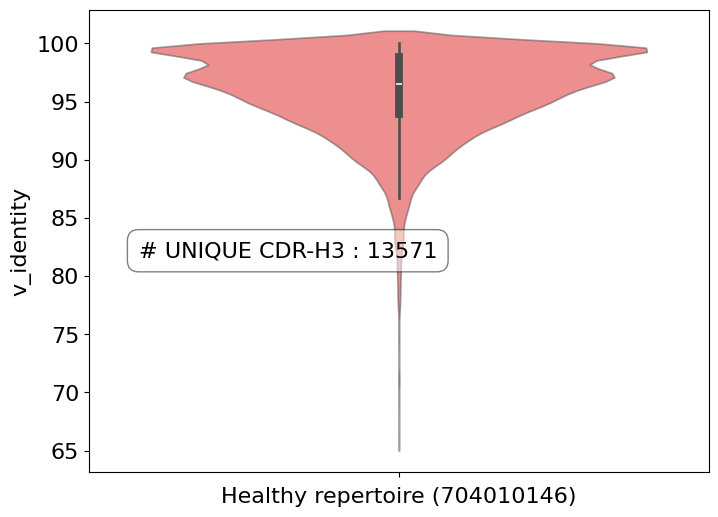

In [6]:
# NO CDRH3 DUPLICATES
hp_v_identity = hp[['v_identity']].sort_values(by='v_identity')
# Violin plot for 'v_identity'
plt.figure(figsize=(8, 6))
violin = sns.violinplot(y='v_identity', data=hp, color='red', )
for patch in violin.collections:
    patch.set_alpha(0.5) 
plt.ylabel('v_identity', fontsize=16)
plt.xlabel('Healthy repertoire (704010146)', fontsize=16)
plt.text(0.08, 0.5, f'# UNIQUE CDR-H3 : {len(hp_v_identity)}', ha='left', va='top', fontsize=16, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5'))
plt.tick_params(axis='both', labelsize=16)

#plt.savefig("./img/healthy_repertoire_704010146.svg", format="svg")
#plt.savefig("./img/healthy_repertoire_704010146.png", format="png")

In [7]:
hp[['sequence_id','cdr3_aa','label']].to_csv('./repertoires/healthy_repertoire_704010146.txt', index =False, header=None)

##### with duplicates

In [8]:
healthy_repertoire = meta_data[meta_data['subject']==704010146].Run.tolist()
print(healthy_repertoire)
hp = pd.read_csv('HIV_NEG/HIV_NEG.tsv',sep='\t')
hp = hp.dropna(subset='cdr3_aa')
# Splitting 'sequence_id' into 'subject' and 'index'
hp[['Run', 'index']] = hp['sequence_id'].str.split('.', expand=True)
hp = hp[hp['Run'].isin(healthy_repertoire) ] 
hp['label'] = 'NON'
hp.head(3)

['SRR7717547', 'SRR7717588', 'SRR7717729']


,sequence_id,sequence,locus,stop_codon,vj_in_frame,v_frameshift,productive,rev_comp,complete_vdj,v_call,...,np2,np2_length,v_family,d_family,j_family,c_family,cdr3_aa_length,Run,index,label
0,SRR7717547.6004,CGGGGAGTCTCTGAAGATCTCCTGTGCAGCCTCTGGATTCACCTTT...,IGH,T,F,F,F,T,F,IGHV3-9*03,...,TGGCATCC,8.0,IGHV3-9,IGHD6-19,IGHJ4,NaN,12,SRR7717547,6004,NON
1,SRR7717547.6005,CGGGGAGTCTCTGAAGATCTCCTGTGTAGCCTCTGGATTCACCTTT...,IGH,F,T,F,T,T,F,IGHV3-7*01,...,TCCGGGTGTG,10.0,IGHV3-7,IGHD1-26,IGHJ4,NaN,12,SRR7717547,6005,NON
2,SRR7717547.6006,CTTCGGAGACCCTGTCCCTCACCTGCACTGTCACTGGTGGCTCCAT...,IGH,F,T,F,T,T,F,IGHV4-59*01,...,CTG,3.0,IGHV4-59,IGHD3-10,IGHJ5,NaN,11,SRR7717547,6006,NON


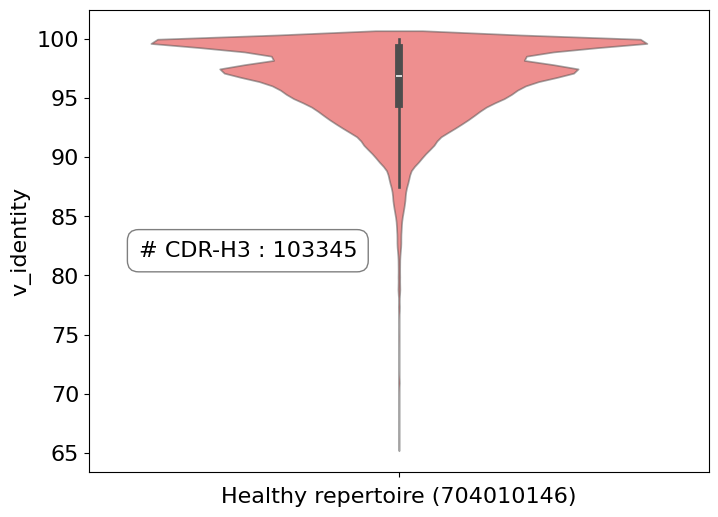

In [9]:
# WITH CDRH3 DUPLICATES
hp_v_identity = hp[['v_identity']].sort_values(by='v_identity')
# Violin plot for 'v_identity'
plt.figure(figsize=(8, 6))
violin = sns.violinplot(y='v_identity', data=hp, color='red', )
for patch in violin.collections:
    patch.set_alpha(0.5) 
plt.ylabel('v_identity', fontsize=16)
plt.xlabel('Healthy repertoire (704010146)', fontsize=16)
plt.text(0.08, 0.5, f'# CDR-H3 : {len(hp_v_identity)}', ha='left', va='top', fontsize=16, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5'))
plt.tick_params(axis='both', labelsize=16)

In [10]:
hp[['sequence_id','cdr3_aa','label']].to_csv('./repertoires/healthy_repertoire_withcdrh3duplicates_704010146.txt', index =False, header=None)

### HIV REPERTOIRE WITH BNABS #2 

##### no duplicates

In [11]:
hiv_repertoire = meta_data[meta_data['subject']==703010619].Run.tolist()
print(hiv_repertoire)
hiv = pd.read_csv('HIV_BNABS/HIV_BNABS.tsv',sep='\t', )
hiv = hiv.dropna(subset='cdr3_aa')
hiv = hiv.drop_duplicates(subset='cdr3_aa')
# Splitting 'sequence_id' into 'subject' and 'index'
hiv[['Run', 'index']] = hiv['sequence_id'].str.split('.', expand=True)
hiv = hiv[hiv['Run'].isin(hiv_repertoire) ]
hiv['label'] = 'BRO'
hiv.head(3)

['SRR7717554', 'SRR7717757', 'SRR7717938']


,sequence_id,sequence,locus,stop_codon,vj_in_frame,v_frameshift,productive,rev_comp,complete_vdj,v_call,...,np2,np2_length,v_family,d_family,j_family,c_family,cdr3_aa_length,Run,index,label
1001,SRR7717554.13008,GGCCTCAGTGAAGGTCTCCTGCAAGGCTTCTGGAGGCACCTTCAGC...,IGH,F,T,F,T,T,F,IGHV1-69*13,...,CC,2.0,IGHV1-69,IGHD5-24,IGHJ5,NaN,12,SRR7717554,13008,BRO
1002,SRR7717554.13009,CTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTT...,IGH,F,F,F,F,T,F,IGHV3-9*01,...,GGTTG,5.0,IGHV3-9,IGHD6-19,IGHJ4,NaN,16,SRR7717554,13009,BRO
1003,SRR7717554.13010,CTGGGGGGTCCCTGAGACTCTCCTGCGCTGTCTATGGTGGGTCCTT...,IGH,F,T,F,T,T,F,"IGHV4-34*01,IGHV4-34*02",...,CTCACCG,7.0,IGHV4-34,IGHD3-22,IGHJ4,NaN,18,SRR7717554,13010,BRO


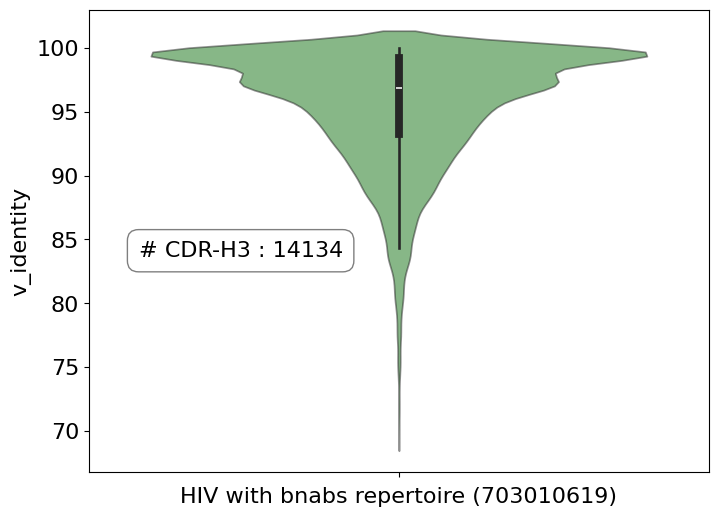

In [12]:
hiv_v_identity = hiv[['v_identity']].sort_values(by='v_identity')
# Violin plot for 'v_identity'
plt.figure(figsize=(8, 6))
violin = sns.violinplot(y='v_identity', data=hiv, color='green')
for patch in violin.collections:
    patch.set_alpha(0.5) 
plt.ylabel('v_identity', fontsize=16)
plt.xlabel('HIV with bnabs repertoire (703010619)', fontsize=16)
plt.text(0.08, 0.5, f'# CDR-H3 : {len(hiv_v_identity)}', ha='left', va='top', fontsize=16, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5'))
plt.tick_params(axis='both', labelsize=16)

#plt.savefig("./img/hiv_repertoire_703010619.svg", format="svg")
#plt.savefig("./img/hiv_repertoire_703010619.png", format="png")

In [13]:
hiv[['sequence_id','cdr3_aa','label']].to_csv('./repertoires/hiv_repertoire_703010619.txt', index =False, header=None)

##### with duplicates

In [18]:
hiv_repertoire = meta_data[meta_data['subject']==703010619].Run.tolist()
print(hiv_repertoire)
hiv = pd.read_csv('HIV_BNABS/HIV_BNABS.tsv',sep='\t', )
hiv = hiv.dropna(subset='cdr3_aa')
# Splitting 'sequence_id' into 'subject' and 'index'
hiv[['Run', 'index']] = hiv['sequence_id'].str.split('.', expand=True)
hiv = hiv[hiv['Run'].isin(hiv_repertoire) ]
hiv['label'] = 'BRO'
hiv.head(3)

['SRR7717554', 'SRR7717757', 'SRR7717938']


,sequence_id,sequence,locus,stop_codon,vj_in_frame,v_frameshift,productive,rev_comp,complete_vdj,v_call,...,np2,np2_length,v_family,d_family,j_family,c_family,cdr3_aa_length,Run,index,label
1001,SRR7717554.13008,GGCCTCAGTGAAGGTCTCCTGCAAGGCTTCTGGAGGCACCTTCAGC...,IGH,F,T,F,T,T,F,IGHV1-69*13,...,CC,2.0,IGHV1-69,IGHD5-24,IGHJ5,NaN,12,SRR7717554,13008,BRO
1002,SRR7717554.13009,CTGGGGGGTCCCTGAGACTCTCCTGTGCAGCCTCTGGATTCACCTT...,IGH,F,F,F,F,T,F,IGHV3-9*01,...,GGTTG,5.0,IGHV3-9,IGHD6-19,IGHJ4,NaN,16,SRR7717554,13009,BRO
1003,SRR7717554.13010,CTGGGGGGTCCCTGAGACTCTCCTGCGCTGTCTATGGTGGGTCCTT...,IGH,F,T,F,T,T,F,"IGHV4-34*01,IGHV4-34*02",...,CTCACCG,7.0,IGHV4-34,IGHD3-22,IGHJ4,NaN,18,SRR7717554,13010,BRO


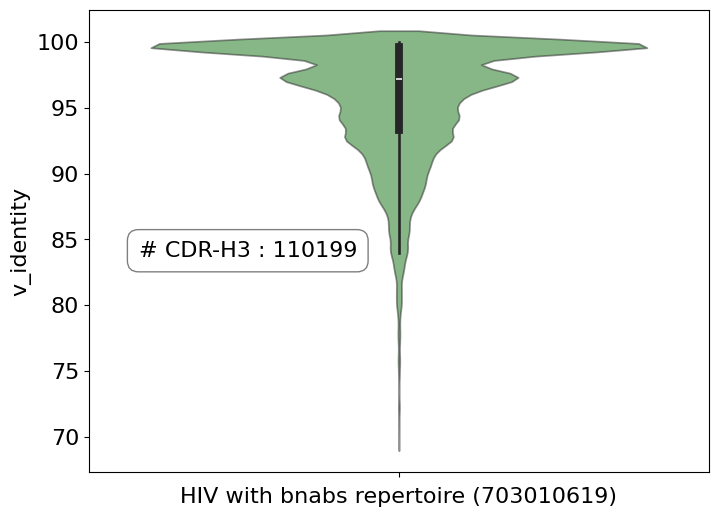

In [19]:
hiv_v_identity = hiv[['v_identity']].sort_values(by='v_identity')
# Violin plot for 'v_identity'
plt.figure(figsize=(8, 6))
violin = sns.violinplot(y='v_identity', data=hiv, color='green')
for patch in violin.collections:
    patch.set_alpha(0.5) 
plt.ylabel('v_identity', fontsize=16)
plt.xlabel('HIV with bnabs repertoire (703010619)', fontsize=16)
plt.text(0.08, 0.5, f'# CDR-H3 : {len(hiv_v_identity)}', ha='left', va='top', fontsize=16, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5'))
plt.tick_params(axis='both', labelsize=16)


In [20]:
hiv[['sequence_id','cdr3_aa','label']].to_csv('./repertoires/hiv_repertoire_withcdrh3duplicates_703010619.txt', index =False, header=None)